In [26]:
# Imports & parameters
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

In [27]:
# Data import
folder = 'ohlcv_binance_perp'
dfs = {}

for filename in os.listdir(folder):
    if filename.endswith('.csv'):
        symbol = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder, filename), parse_dates=['date'] if 'date' in pd.read_csv(os.path.join(folder, filename), nrows=0).columns else [0])
        df = df.set_index(df.columns[0])
        df.sort_index(inplace=True)
        dfs[symbol] = df

In [28]:
# Build close price dataframe from all symbols
close_df = pd.DataFrame({symbol: df['close'] for symbol, df in dfs.items()})
close_df = close_df.sort_index()

# Compute daily returns
returns = close_df.pct_change()

# Drop rows where all values are NaN
returns = returns.dropna(how='all')

print(f"Close price dataframe shape: {close_df.shape}")
print(f"Returns dataframe shape: {returns.shape}")
print(f"\nClose prices (last 5 rows):")

Close price dataframe shape: (2235, 665)
Returns dataframe shape: (2234, 665)

Close prices (last 5 rows):


C:\Users\blazo\AppData\Local\Temp\ipykernel_45172\3126570250.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_df.pct_change()


In [29]:
# Get the most recent date in the returns dataframe
most_recent_date = returns.index.max()

# Calculate the cutoff date (2 years ago)
cutoff_date = pd.Timestamp('2021-01-01')

listing_dates = returns.apply(lambda col: col.first_valid_index())

# Filter listing_dates to only include symbols listed after the cutoff
recent_listings = listing_dates[listing_dates > cutoff_date]

# Filter returns dataframe to only include these symbols
returns = returns[recent_listings.index]

print(f"Filtered to {len(returns.columns)} symbols listed in the last 2 years")
print(f"Cutoff date: {cutoff_date}")
print(f"Returns dataframe shape: {returns.shape}")

Filtered to 584 symbols listed in the last 2 years
Cutoff date: 2021-01-01 00:00:00
Returns dataframe shape: (2234, 584)


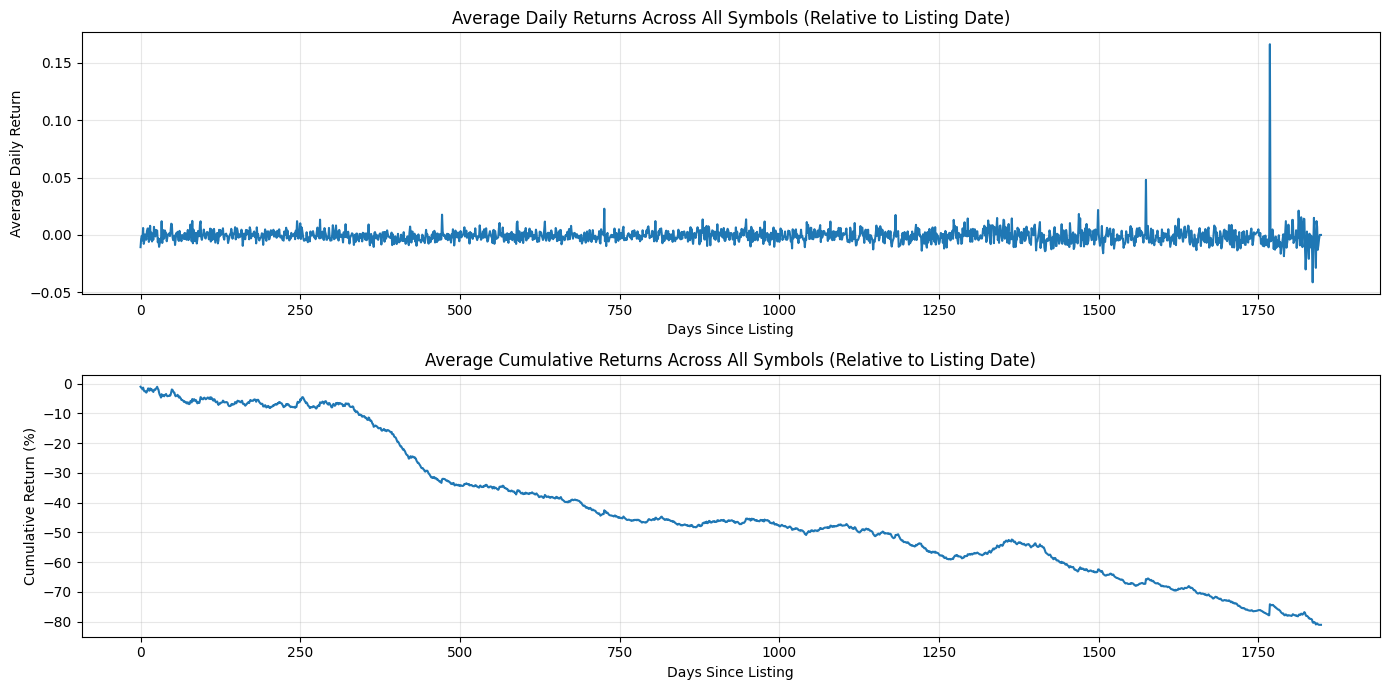

Number of symbols analyzed: 584
Maximum days of data: 1849

Average cumulative return after:
  7 days: -2.56%
  30 days: -3.78%
  90 days: -6.33%
  180 days: -5.42%
  365 days: -14.53%
  730 days: -43.47%
  1095 days: -47.63%


In [31]:
# Create a list to store aligned returns for each symbol
aligned_returns_list = []

for symbol in returns.columns:
    listing_date = listing_dates[symbol]
    
    if pd.isna(listing_date):
        continue
    
    # Get returns from listing date onwards
    symbol_returns = returns.loc[listing_date:, symbol].dropna()
    
    # Create a series indexed by days since listing (0, 1, 2, ...)
    days_since_listing = pd.Series(
        symbol_returns.values,
        index=range(len(symbol_returns)),
        name=symbol
    )
    
    aligned_returns_list.append(days_since_listing)

# Combine all aligned returns into a DataFrame
aligned_returns_df = pd.concat(aligned_returns_list, axis=1)

# Calculate average return for each day since listing
avg_returns_since_listing = aligned_returns_df.mean(axis=1)

# Calculate cumulative returns
cumulative_avg_returns = (1 + avg_returns_since_listing).cumprod() - 1

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(avg_returns_since_listing.index, avg_returns_since_listing.values)
plt.xlabel('Days Since Listing')
plt.ylabel('Average Daily Return')
plt.title('Average Daily Returns Across All Symbols (Relative to Listing Date)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(cumulative_avg_returns.index, cumulative_avg_returns.values * 100)
plt.xlabel('Days Since Listing')
plt.ylabel('Cumulative Return (%)')
plt.title('Average Cumulative Returns Across All Symbols (Relative to Listing Date)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number of symbols analyzed: {len(aligned_returns_list)}")
print(f"Maximum days of data: {len(avg_returns_since_listing)}")
print(f"\nAverage cumulative return after:")
for days in [7, 30, 90, 180, 365, 730, 1095]:  # 1 week, 1 month, 3 months, 6 months, 1 year, 2 years, 3 years
    if days < len(cumulative_avg_returns):
        print(f"  {days} days: {cumulative_avg_returns.iloc[days]:.2%}")